# [**Forecasting with Linear Regression**](https://www.kaggle.com/code/cabaxiom/tps-sep-22-eda-and-linear-regression-baseline)

### **Contents**

- **EDA** - A very brief EDA, showing only the essentials
- **Aggregating Categorical Variables** - A continuation of the EDA, showing that we should be able to forecast the aggregated time series (daily total sales) and then disaggregate the forecasts based on historical proportions without penalising performance
- **Total Sales Forecast** - Forecast the total number of sales across all categorical variables using Linear Regression for 2021.
- **Product Sales Ratio Forecast** - Forecast the ratio of sales between products for 2021
- **Dissagregating Total Sales Forecast** - Disagreggate the Total Sales forecasts, to get the forecast for each categorical variable

### **References**

This work and approach was inspired by:
- [[TPS-SEP-22] EDA and Linear Regression Baseline](https://www.kaggle.com/code/cabaxiom/tps-sep-22-eda-and-linear-regression-baseline)
- [TPS2209_Ridge_LGBM_EDA_TopDownApproach](https://www.kaggle.com/code/ehekatlact/tps2209-ridge-lgbm-eda-topdownapproach) by [ehekatlact](https://www.kaggle.com/ehekatlact)

In [1]:
# ! kaggle competitions download -c tabular-playground-series-sep-2022

In [2]:
# ! unzip tabular-playground-series-sep-2022.zip -d data/

# **Preliminaries**

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge, ElasticNet, LinearRegression

sns.set_style('darkgrid')

In [4]:
train_df = pd.read_csv("data/train.csv", parse_dates=["date"])
original_train_df = train_df.copy()
test_df = pd.read_csv("data/test.csv", parse_dates=["date"])

# **EDA**

## **Categorical variables**

In [5]:
display(train_df.head())
display(test_df.head())

row_id       date  country       store                           product  \
0       0 2017-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques   
1       1 2017-01-01  Belgium  KaggleMart            Kaggle Getting Started   
2       2 2017-01-01  Belgium  KaggleMart                Kaggle Recipe Book   
3       3 2017-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose   
4       4 2017-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques   

   num_sold  
0       663  
1       615  
2       480  
3       710  
4       240

row_id       date  country       store                           product
0   70128 2021-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques
1   70129 2021-01-01  Belgium  KaggleMart            Kaggle Getting Started
2   70130 2021-01-01  Belgium  KaggleMart                Kaggle Recipe Book
3   70131 2021-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose
4   70132 2021-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques

In [6]:
ROW_ID = train_df.columns[0]
DATE = train_df.columns[1]
COUNTRY = train_df.columns[2]
STORE = train_df.columns[3]
PRODUCT = train_df.columns[4]
NUM_SOLD = train_df.columns[5]

GROUPBY_ATTR = [COUNTRY, STORE, PRODUCT]
RATIOS = "ratios"

**Observations:**
- There are 3 categorical columns that together describe a univariate time series. Country, Store and Product.

Lets see which countries, stores and products we have data for:

In [7]:
def val_count_df(df:pd.DataFrame, column_name:str, sort_by_column_name=False):
    value_count = df[column_name].value_counts().reset_index().rename(columns={column_name:"Value Count","index":column_name}).set_index(column_name)
    value_count["Percentage"] = df[column_name].value_counts(normalize=True)*100
    value_count = value_count.reset_index()
    if sort_by_column_name:
        value_count = value_count.sort_values(column_name)
    return value_count



def plot_and_display_valuecounts(df:pd.DataFrame, column_name:str, sort_by_column_name=False):
    val_count = val_count_df(df, column_name, sort_by_column_name)
    #display(val_count)
    plt.figure(figsize=(5, 5))
    val_count.set_index(column_name).plot.pie(y="Value Count", figsize=(5,5), legend=False, ylabel='');
    plt.title(column_name, fontsize=50)
    plt.show()

<Figure size 360x360 with 0 Axes>

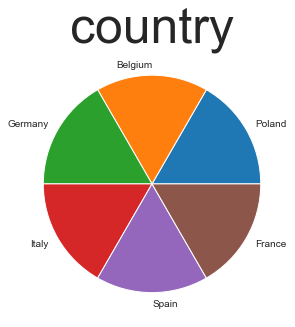

<Figure size 360x360 with 0 Axes>

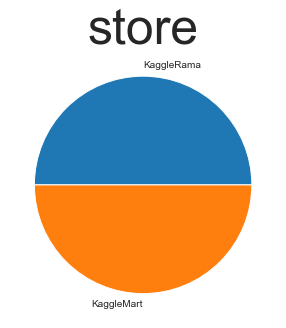

<Figure size 360x360 with 0 Axes>

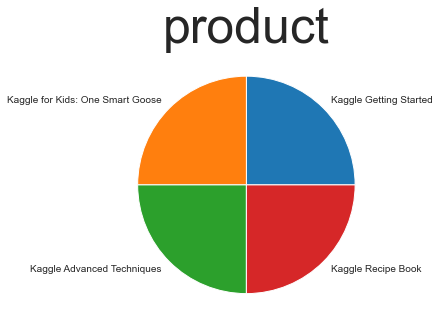

In [8]:
for col in GROUPBY_ATTR:
    plot_and_display_valuecounts(train_df, col)

Every group seems to occur in equal amounts, but lets double check to see if every country contains every store, and if every store sells each product:

In [9]:
train_df.groupby(GROUPBY_ATTR)[NUM_SOLD].count()

country  store       product                         
Belgium  KaggleMart  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                     Kaggle for Kids: One Smart Goose    1461
         KaggleRama  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                     Kaggle for Kids: One Smart Goose    1461
France   KaggleMart  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                     Kaggle for Kids: One Smart Goose    1461
         KaggleRama  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                

Yes, every country contains every store and every store contains every product. This gives us **48 univariate time series** all of **length 1461**

## **Time series**

In [10]:
print("Train - Earliest date:", train_df[DATE].min())
print("Train - Latest date:", train_df[DATE].max())

print("Test - Earliest date:", test_df[DATE].min())
print("Test - Latest date:", test_df[DATE].max())

Train - Earliest date: 2017-01-01 00:00:00
Train - Latest date: 2020-12-31 00:00:00
Test - Earliest date: 2021-01-01 00:00:00
Test - Latest date: 2021-12-31 00:00:00


- We have **4 years** of data **from 2017-01-01 to 2020-12-31** to train occuring at **daily frequency**.
- We are required to forecast 1 year of data, **from 2021-01-01 to 2021-12-31**

In [11]:
weekly_df = train_df.groupby([COUNTRY, STORE, PRODUCT, pd.Grouper(key=DATE, freq="W")])[NUM_SOLD].sum().reset_index()
monthly_df = train_df.groupby([COUNTRY, STORE, PRODUCT, pd.Grouper(key=DATE, freq="MS")])[NUM_SOLD].sum().reset_index()

In [12]:
display(weekly_df.head())
display(monthly_df.head())

country       store                     product       date  num_sold
0  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-01-01       663
1  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-01-08      3362
2  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-01-15      2757
3  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-01-22      2863
4  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-01-29      2924

country       store                     product       date  num_sold
0  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-01-01     13345
1  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-02-01     12556
2  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-03-01     14137
3  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-04-01     14575
4  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-05-01     14338

In [13]:
def plot_all(df:pd.DataFrame):
    f, axes = plt.subplots(2, 2, figsize=(20,15), sharex = True, sharey=True)
    f.tight_layout()
    for n, prod in enumerate(df[PRODUCT].unique()):
        plot_df = df.loc[df[PRODUCT] == prod]
        sns.lineplot(data=plot_df, x=DATE, y=NUM_SOLD, hue=COUNTRY, style=STORE, ax=axes[n//2,n%2])
        axes[n//2,n%2].set_title("Product: " + str(prod), fontsize=20)

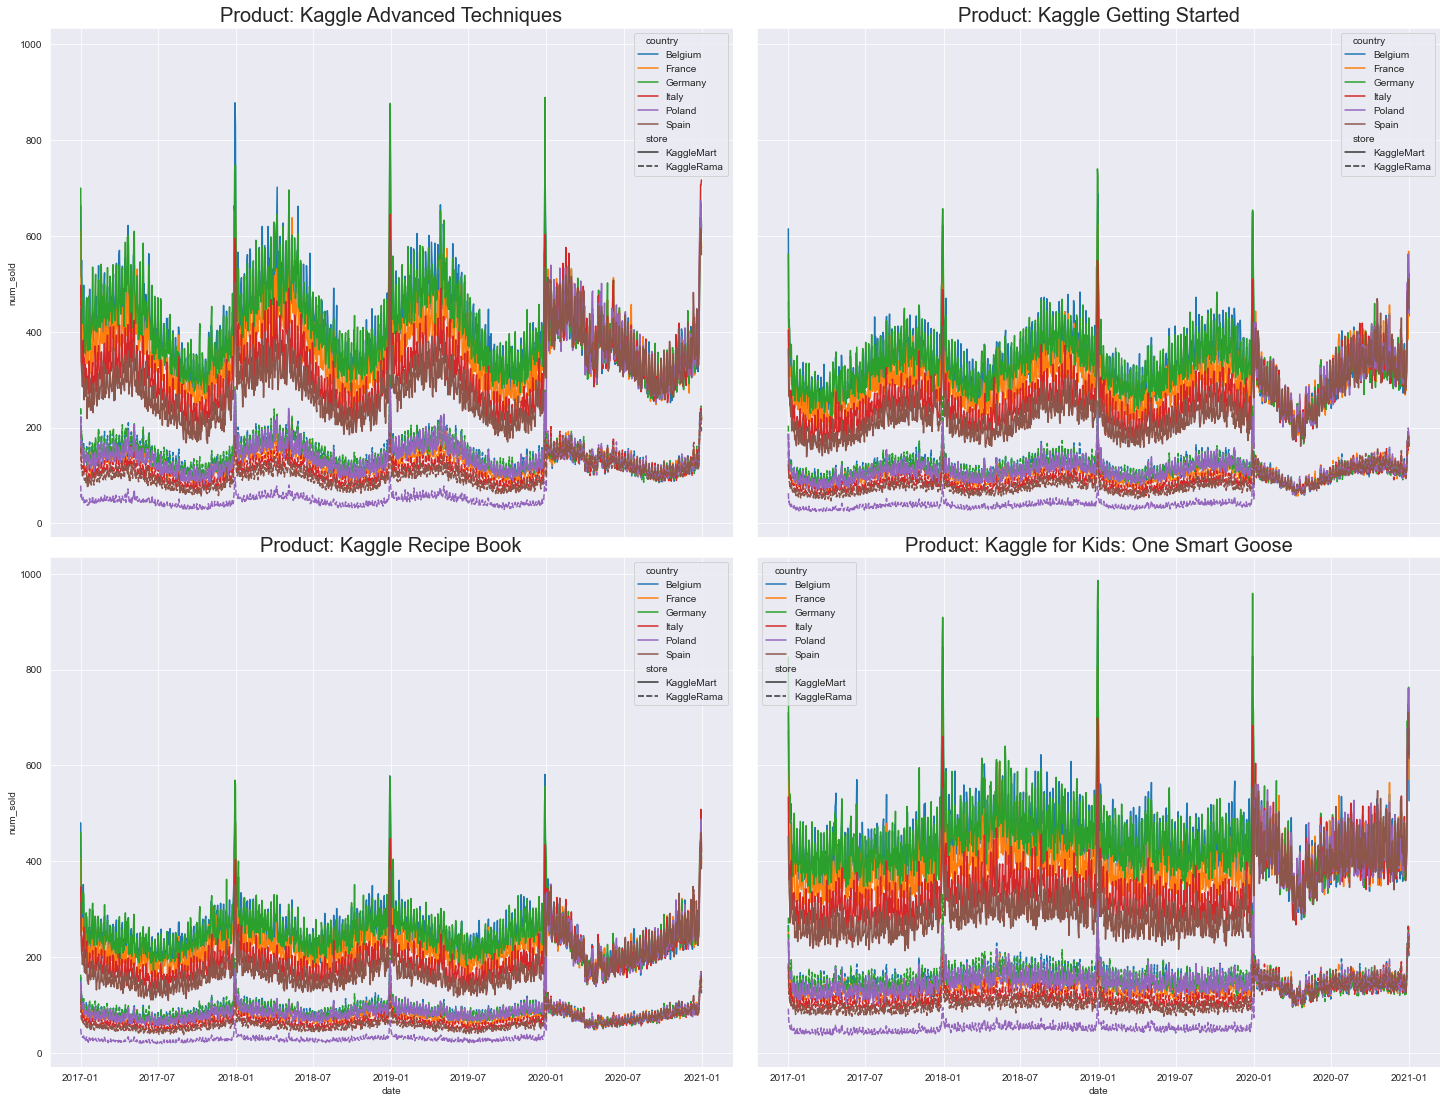

In [14]:
plot_all(train_df)

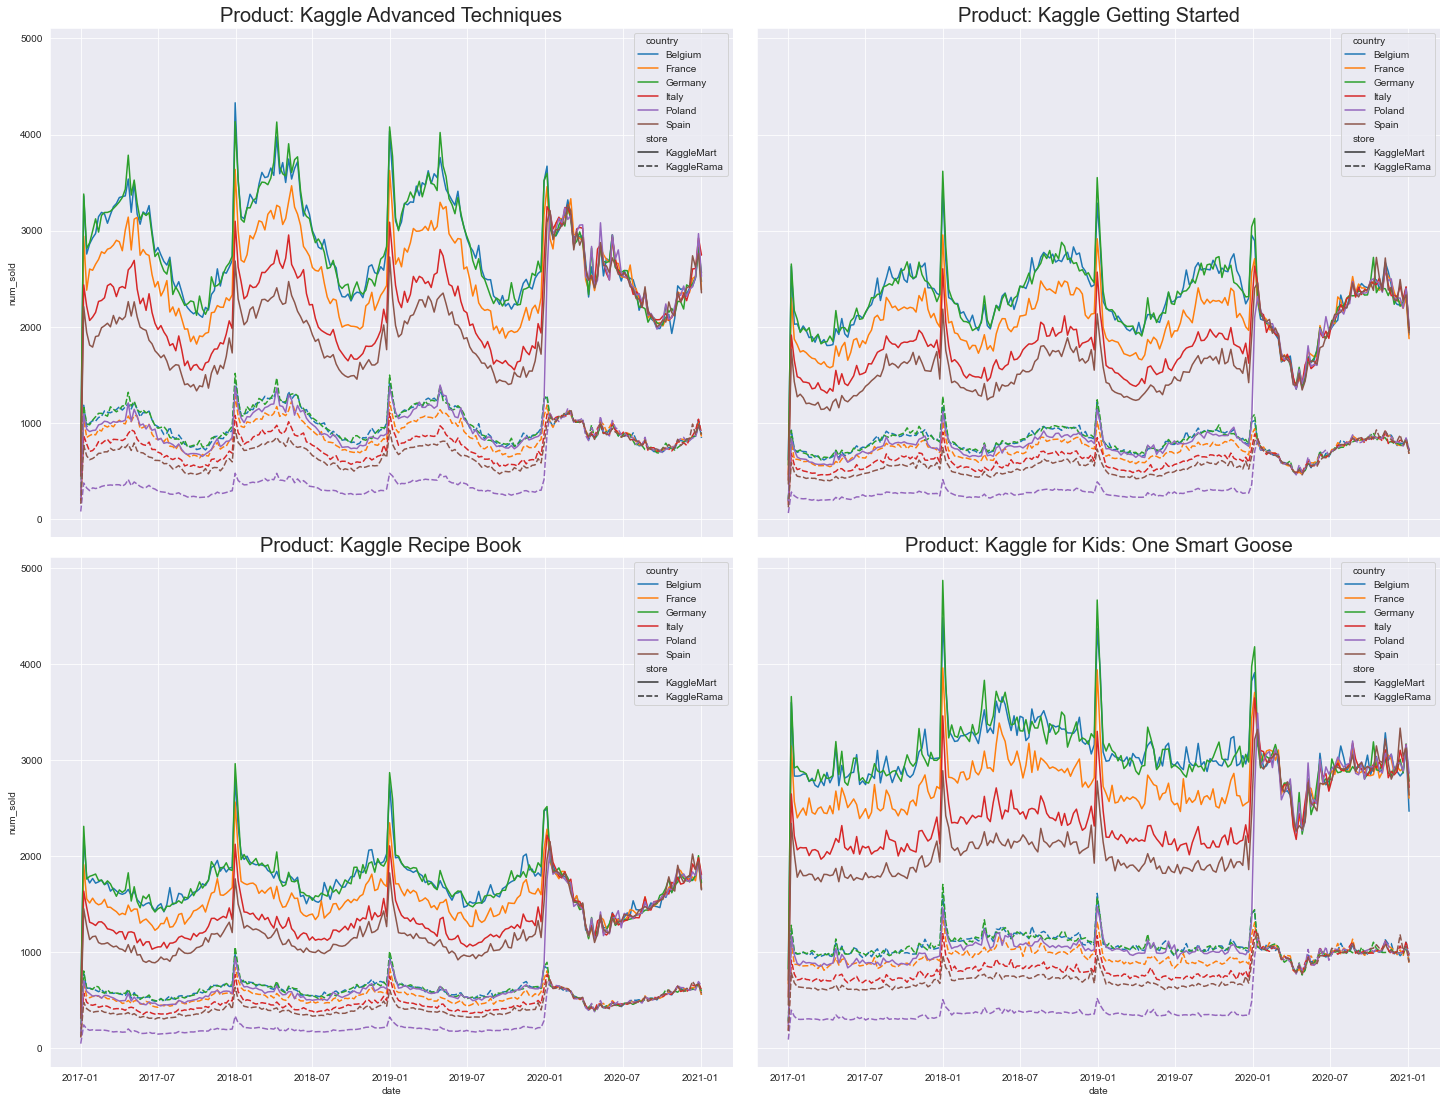

In [15]:
plot_all(weekly_df)

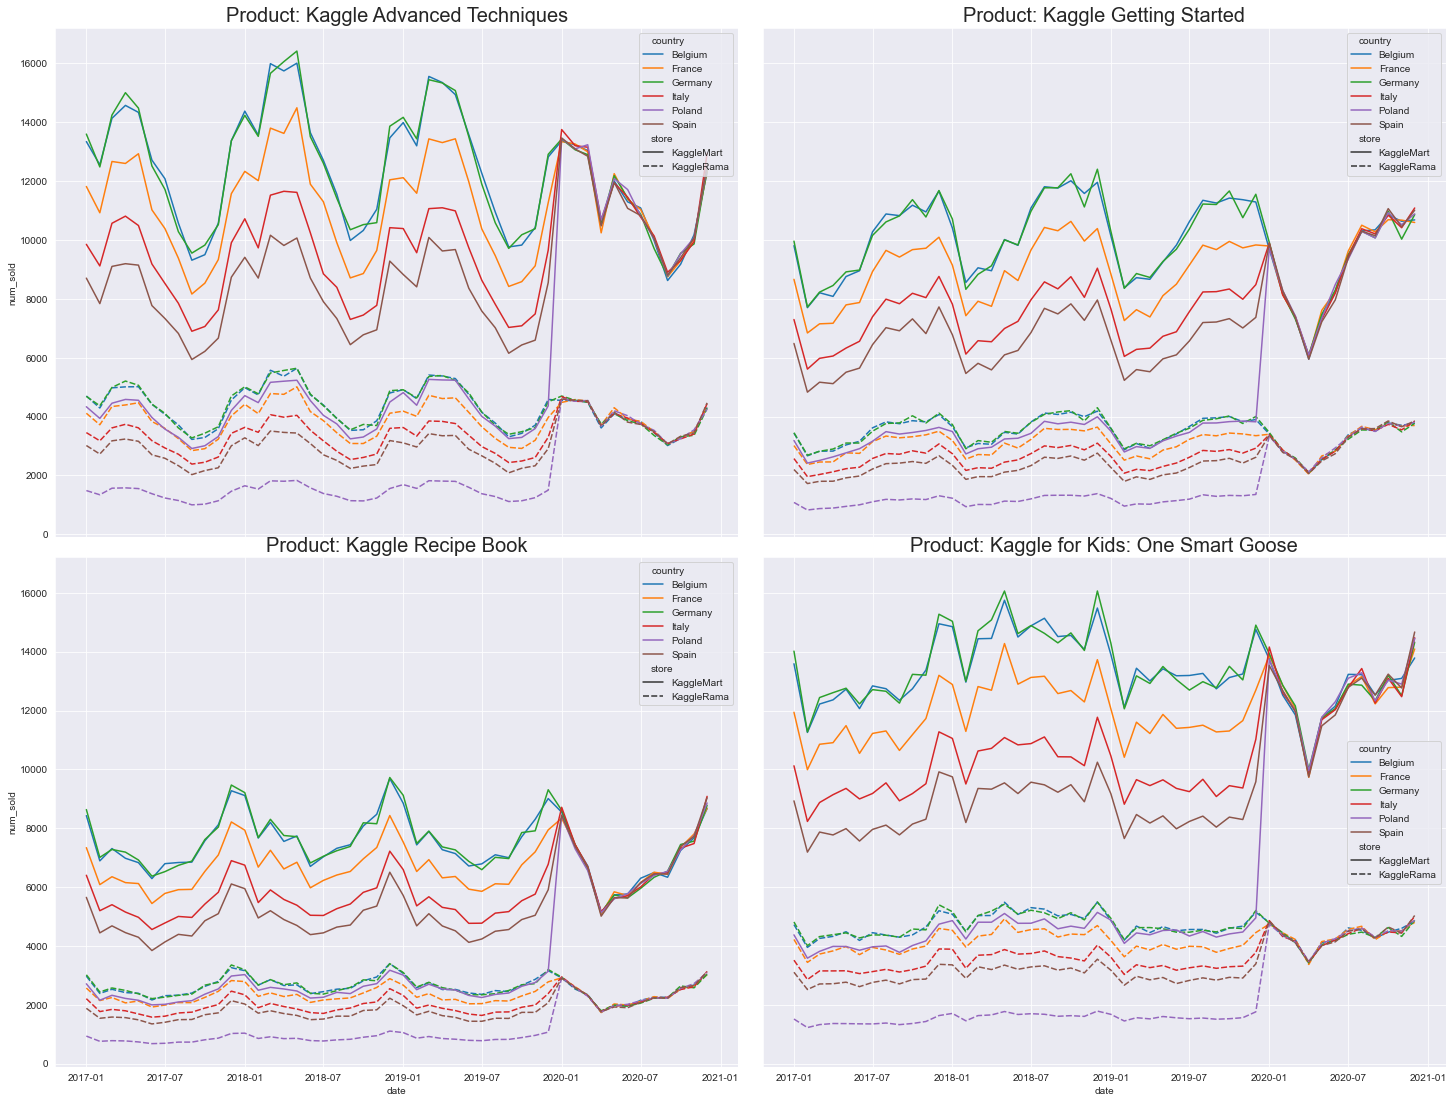

In [16]:
plot_all(monthly_df)

**Observations:**

- The year 2020 is significantly different to other years, with sales being almost identical between countries.
- Each product has a different pattern in number of sales.
- It looks a lot like the pattern in sales between stores is identical. With KaggleMart and KaggleRama following the same pattern but with KaggleRama having less sales.
- Similarly it looks like the pattern in sales between all countries is identical, just with the magnitude of sales being different.

# **Aggregating Time Series**

First we need to show that its a good idea to aggregate the time series across each of the three categorical variables: Store, Country and Product.

### **Store**

Lets test to see if the pattern between stores is the same, regardless of product or country.

In [17]:
store_weights = train_df.groupby(STORE)[NUM_SOLD].sum()/train_df[NUM_SOLD].sum()
store_weights

store
KaggleMart    0.742515
KaggleRama    0.257485
Name: num_sold, dtype: float64

In [35]:
pd.DataFrame(train_df.groupby([DATE, STORE])[NUM_SOLD].sum().reset_index()).pivot(index=DATE, columns=STORE, values=NUM_SOLD).corr()

store       KaggleMart  KaggleRama
store                             
KaggleMart    1.000000    0.995038
KaggleRama    0.995038    1.000000

The <span style="color:yellow">**correlation**</span> between different **(normalized)** stores is about to 1, which is incredibly high.  
Underpart shows the graphical relationship.

In [31]:
store_ratio_over_time = (weekly_df.groupby([DATE, STORE])[NUM_SOLD].sum() / weekly_df.groupby([DATE])[NUM_SOLD].sum()).reset_index()
display(store_ratio_over_time.head())

date       store  num_sold
0 2017-01-01  KaggleMart  0.736972
1 2017-01-01  KaggleRama  0.263028
2 2017-01-08  KaggleMart  0.741604
3 2017-01-08  KaggleRama  0.258396
4 2017-01-15  KaggleMart  0.743408

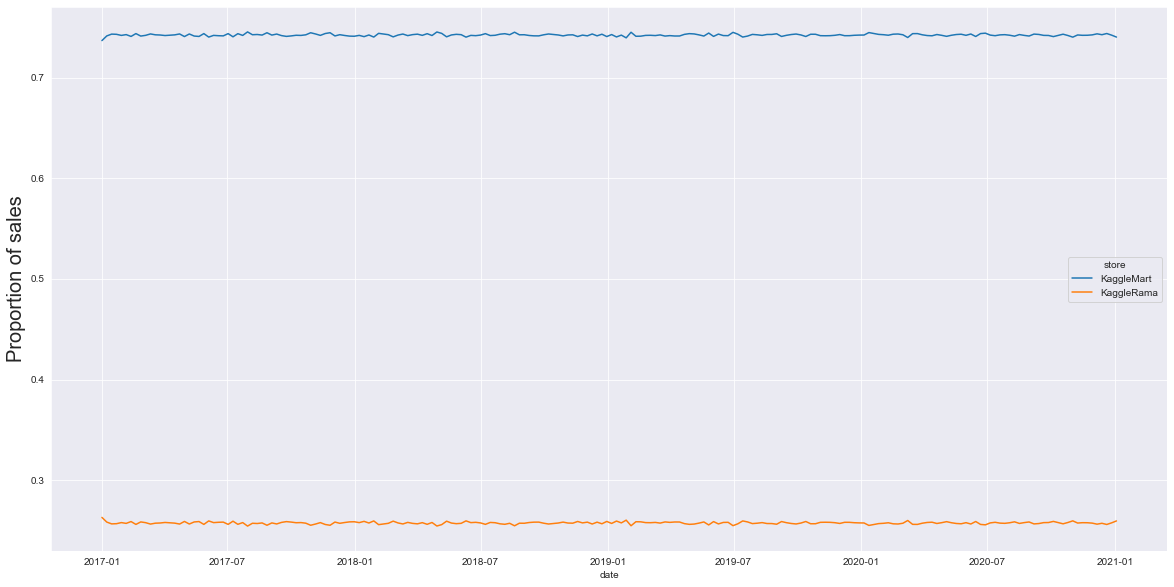

In [35]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=store_ratio_over_time, x=DATE, y=NUM_SOLD, hue=STORE);
ax.set_ylabel("Proportion of sales", fontdict={"fontsize":20});

KaggleMart appears to consistantly have ~74.25% of the total number of sales. Lets multiply all sales in KaggleRama by a constant so they are comparable to sales in KaggleMart. If the lines between stores overlap perfectly then trend and seasonality are not unique to the store and we can ignore its effect.

In [44]:
def adjust_store(df:pd.DataFrame, store_weights=store_weights):
    new_df = df.copy()
    weights = store_weights.loc["KaggleMart"] / store_weights
    for store in weights.index:
        new_df.loc[new_df[STORE] == store, NUM_SOLD] = new_df.loc[new_df[STORE] == store, NUM_SOLD] * weights[store]
    return new_df

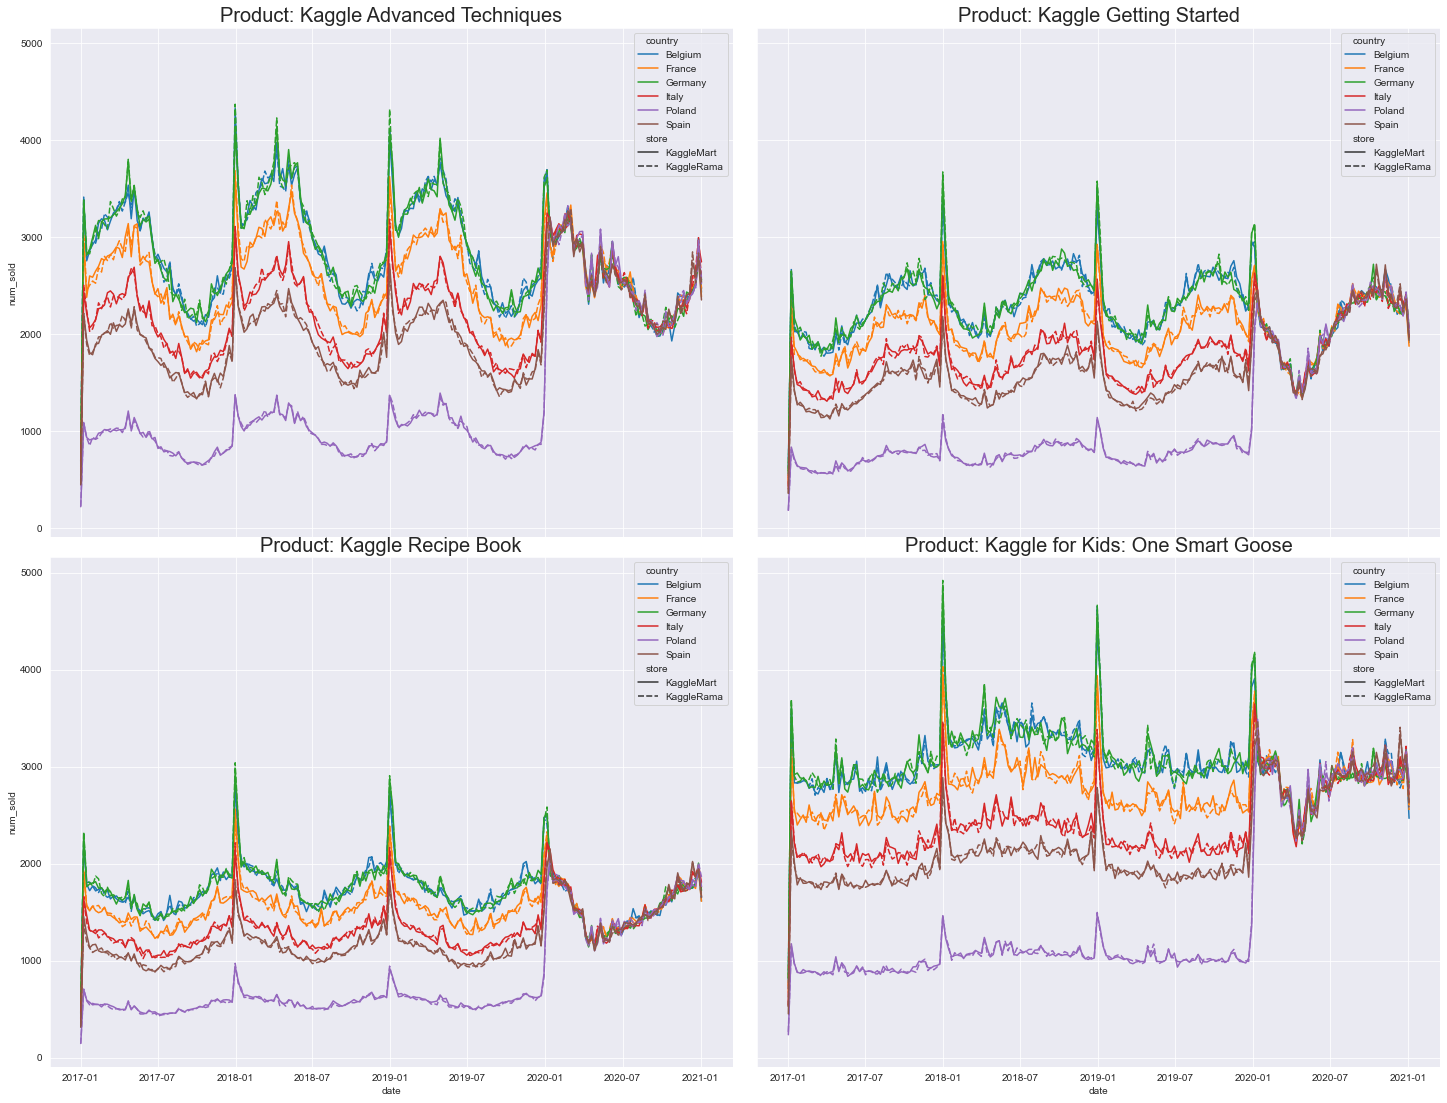

In [47]:
# plot_all(adjust_store(monthly_df))
plot_all(adjust_store(weekly_df))

**Observations:**
- The dashed and solid lines representing the different stores overlap almost perefectly for all dates.

**Insight:**

- Don't pay attention to the values on the y axis, it doesn't mean anything. The purpose of the graph is only to see if the lines overlap.
- Trend and seasonality are not unique to the store and we can ignore its effect. All differences in sales can be explained by a single constant regardless of time.
- This means we can forecast the store aggregated timeseries, and then disaggregating the forecasts based on historical proportions

### **Countries**

Lets see if the difference in countries, **prior to 2020**, can also be explained by a single constant

In [53]:
country_weights = train_df.loc[train_df[DATE] < "2020-01-01"].groupby(COUNTRY)[NUM_SOLD].sum()/train_df.loc[train_df[DATE] < "2020-01-01", NUM_SOLD].sum()
country_weights

country
Belgium    0.218930
France     0.191360
Germany    0.219586
Italy      0.159383
Poland     0.071348
Spain      0.139393
Name: num_sold, dtype: float64

In [36]:
pd.DataFrame(train_df.loc[train_df[DATE] < "2020-01-01"].groupby([DATE, COUNTRY])[NUM_SOLD].sum().reset_index()).pivot(index=DATE, columns=COUNTRY, values=NUM_SOLD).corr()

country   Belgium    France   Germany     Italy    Poland     Spain
country                                                            
Belgium  1.000000  0.963096  0.952517  0.941220  0.934343  0.927649
France   0.963096  1.000000  0.947534  0.937582  0.923121  0.922895
Germany  0.952517  0.947534  1.000000  0.943863  0.927139  0.932834
Italy    0.941220  0.937582  0.943863  1.000000  0.926192  0.955961
Poland   0.934343  0.923121  0.927139  0.926192  1.000000  0.916018
Spain    0.927649  0.922895  0.932834  0.955961  0.916018  1.000000

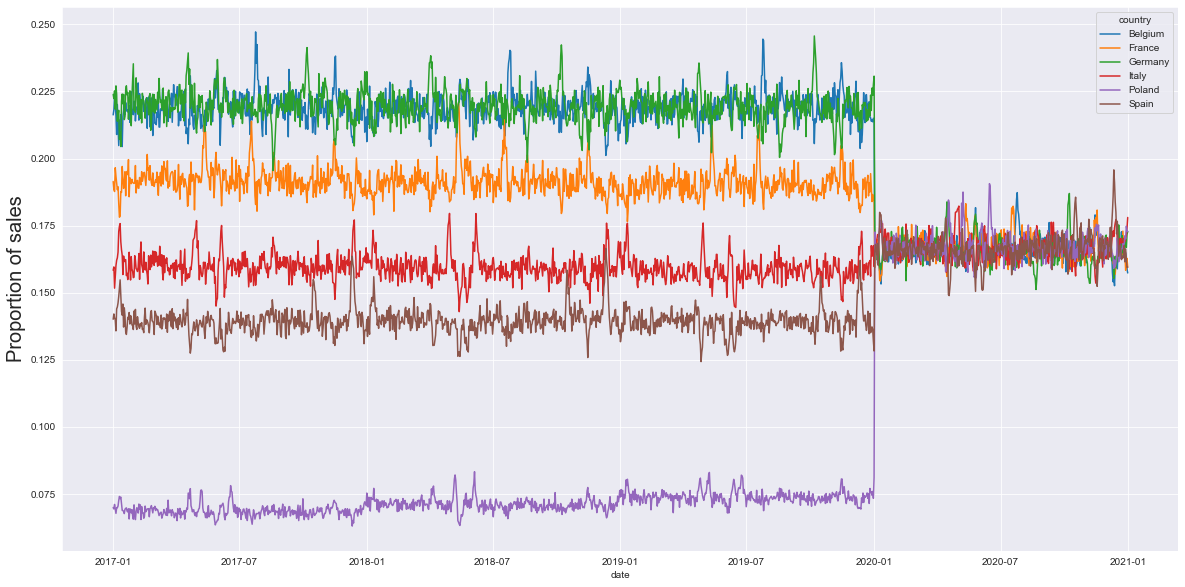

In [54]:
country_ratio_over_time = (train_df.groupby([DATE,COUNTRY])[NUM_SOLD].sum() / train_df.groupby([DATE])[NUM_SOLD].sum()).reset_index()
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = country_ratio_over_time, x=DATE, y=NUM_SOLD, hue=COUNTRY);
ax.set_ylabel("Proportion of sales", fontdict={"fontsize":20});

Lets multiply all countries by a constant so they are comparable with Belgium.

In [61]:
def adjust_country(df:pd.DataFrame):
    new_df = df.copy()
    
    weights = country_weights.loc["Belgium"] / country_weights
    
    for country in weights.index:
        new_df.loc[(new_df[COUNTRY] == country) & (new_df[DATE] < "2020-01-01"), NUM_SOLD] *= weights[country]
    return new_df

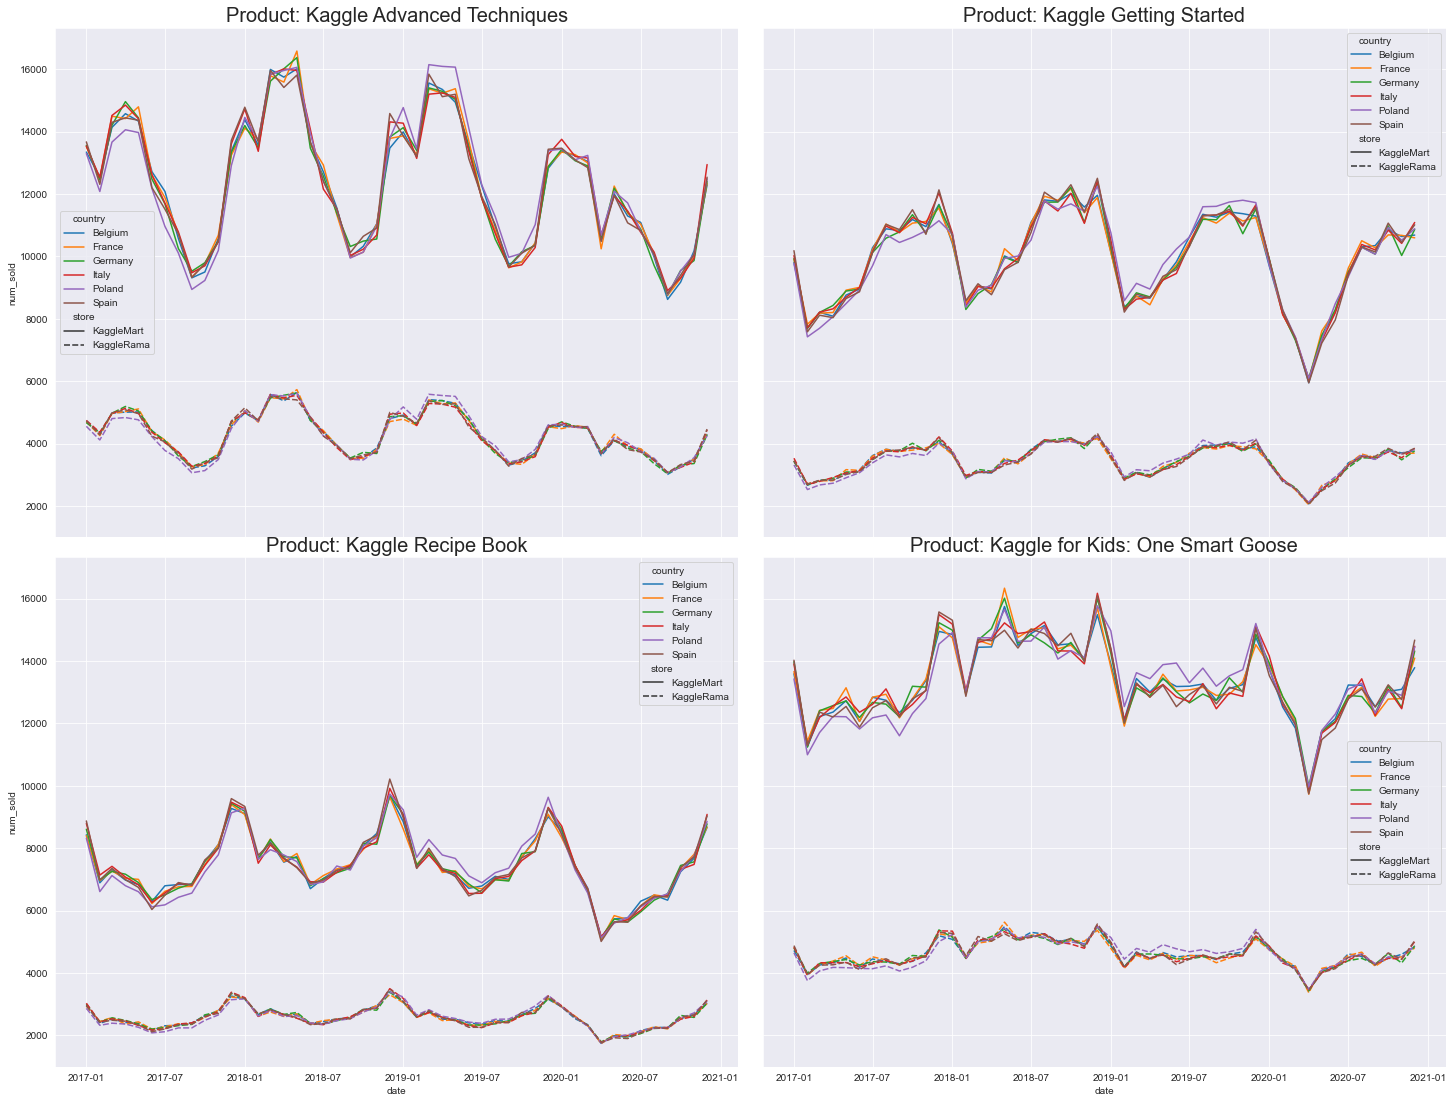

In [60]:
plot_all(adjust_country(monthly_df))

**Observations:**

- It doesn't seem too bad, although Poland seems a little off
- This means we can forecast the country aggregated series, and then disaggregating the forecasts based on historical proportions
- As countries in 2020 behave differently we can dissagregate based on 2020 proportions (i.e. equally).

### **Country and Store**

Lets try doing this to both country and store at the same time.

In the plots we're effectively making all time series inline with the Belgium KaggleMart store by multiplying by a constant.

In [32]:
def adjust_country_store(df:pd.DataFrame):
    new_df = df.copy()
    
    store_weights_ = store_weights.loc["KaggleMart"] / store_weights
    country_weights_ = country_weights.loc["Belgium"] / country_weights
    
    for country in country_weights_.index:
        new_df.loc[(new_df[COUNTRY] == country) & (new_df[DATE] < "2020-01-01"), NUM_SOLD] *= country_weights_[country]
    for store in store_weights_.index:
        new_df.loc[new_df[STORE] == store, NUM_SOLD] *= store_weights_[store]
    plot_all(new_df)

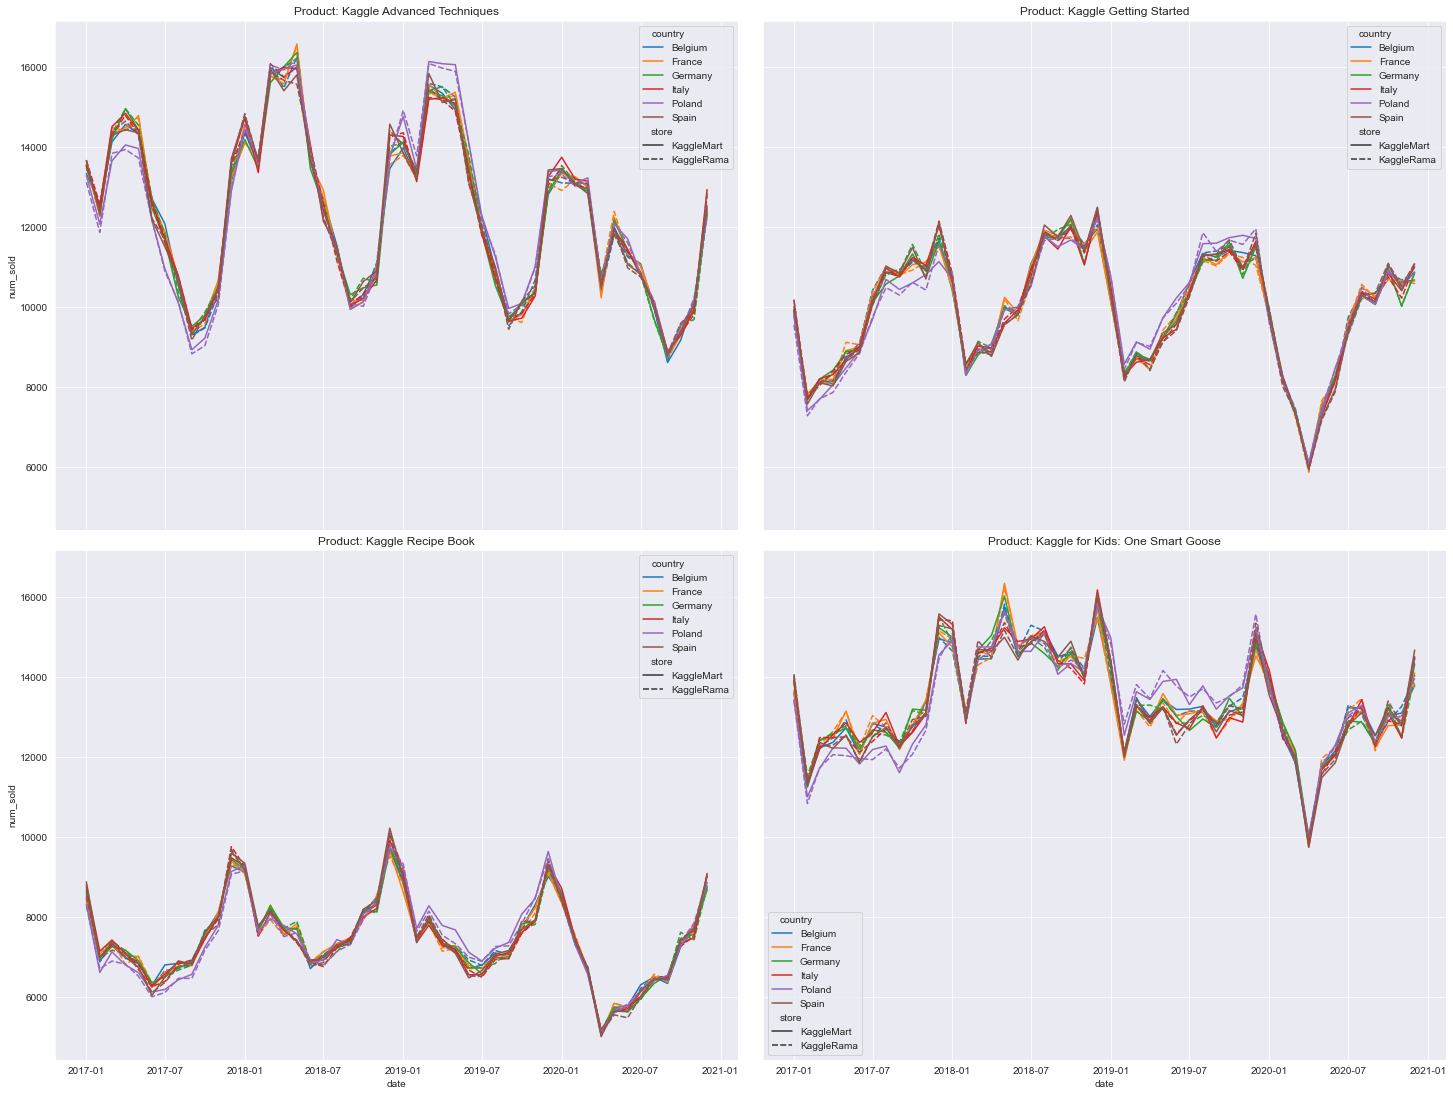

In [33]:
plot_all(adjust_country_store(monthly_df))
#plot_adjust_country_store(weekly_df)

**Observations**

It's not 100% perfect, particularly for Poland, but it seems pretty good.

**Insights**

We should be able to aggregate store together to make the forecast, and then disaggregate using the ratios of historical net sales between stores to get the actual forecast for each store. Country is a little different as from 2020 onwards all countries are the same, so we can can give all countries an equal proportion of sales, or we can assume 2020 was an exception (probably a poor assumption) and use the countries ratios calculated before 2020 to divide the forecast.

### **Product**

Product requires a different approach

In [78]:
product_df = train_df.groupby([DATE,"product"])[NUM_SOLD].sum().reset_index()

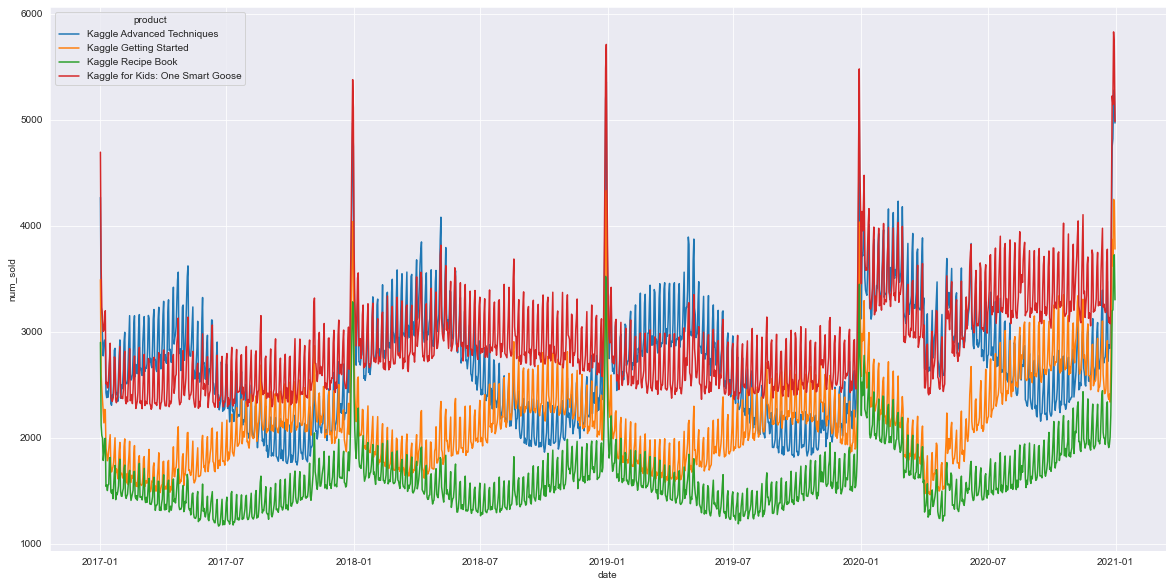

In [66]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=product_df, x=DATE, y=NUM_SOLD, hue="product");

**Product ratio for each date**

In [152]:
product_df.pivot(index=DATE, columns=PRODUCT, values=NUM_SOLD)

product     Kaggle Advanced Techniques  Kaggle Getting Started  \
date                                                             
2017-01-01                        4267                    3492   
2017-01-02                        3242                    2597   
2017-01-03                        3173                    2463   
2017-01-04                        2948                    2354   
2017-01-05                        2773                    2232   
...                                ...                     ...   
2020-12-27                        4749                    3870   
2020-12-28                        4819                    3622   
2020-12-29                        5226                    4248   
2020-12-30                        5281                    4233   
2020-12-31                        4968                    3780   

product     Kaggle Recipe Book  Kaggle for Kids: One Smart Goose  
date                                                              
2017-01-01                2900                              4693  
2017-01-02                2119                              3620  
2017-01-03                2022                              3226  
2017-01-04                1998                              3145  
2017-01-05                1787                              3003  
...                        ...                               ...  
2020-12-27                3199                              5224  
2020-12-28                3205                              5143  
2020-12-29                3575                              5827  
2020-12-30                3725                              5699  
2020-12-31                3301                              4982  

[1461 rows x 4 columns]

In [79]:
product_ratio_df = product_df.pivot(index=DATE, columns=PRODUCT, values=NUM_SOLD)
product_ratio_df = product_ratio_df.apply(lambda x: x/x.sum(),axis=1)
product_ratio_df = product_ratio_df.stack().rename(RATIOS).reset_index()
product_ratio_df.head(4)

date                           product    ratios
0 2017-01-01        Kaggle Advanced Techniques  0.277944
1 2017-01-01            Kaggle Getting Started  0.227462
2 2017-01-01                Kaggle Recipe Book  0.188900
3 2017-01-01  Kaggle for Kids: One Smart Goose  0.305693

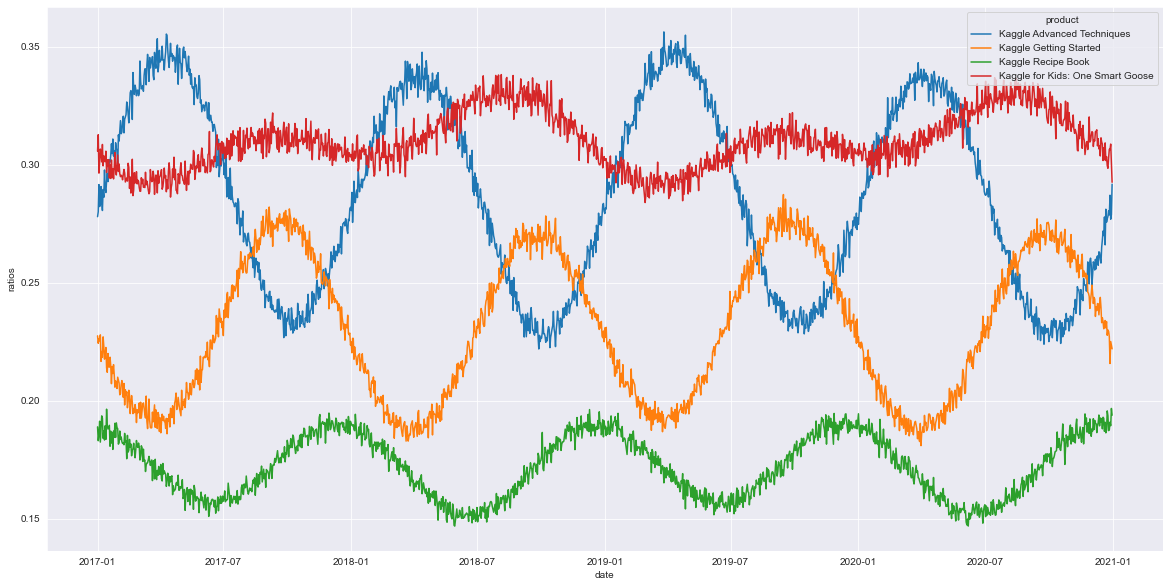

In [37]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = product_ratio_df, x=DATE, y=RATIOS, hue=PRODUCT);

**Observations**

The product ratio shows clear sinsidual lines for each product, with a period of 2 years.

**Insight**

As we have a clear seasonal pattern of the ratio of sales for each product, we do not need to forecast each product individually (or treat product as a categorical variable etc.). Instead we can forecast the sum of all sales each day, then afterwards convert the forecasted sum down to the forecast for each product, using the forecasted **ratios** for each date.

**Conclusions** 

All this together means we only need to forecast 2 time series:
1. The total sales each day
2. The ratio in number of sales for each product each day

Once we have completed the forecasts we can break the forecast down into the 3 categorical variables: Product, Country and Store.

## **Aggregated Time Series**

Lets take a look at the aggregated time series.

In [37]:
sold_df = train_df.groupby([DATE])[NUM_SOLD].sum().reset_index()

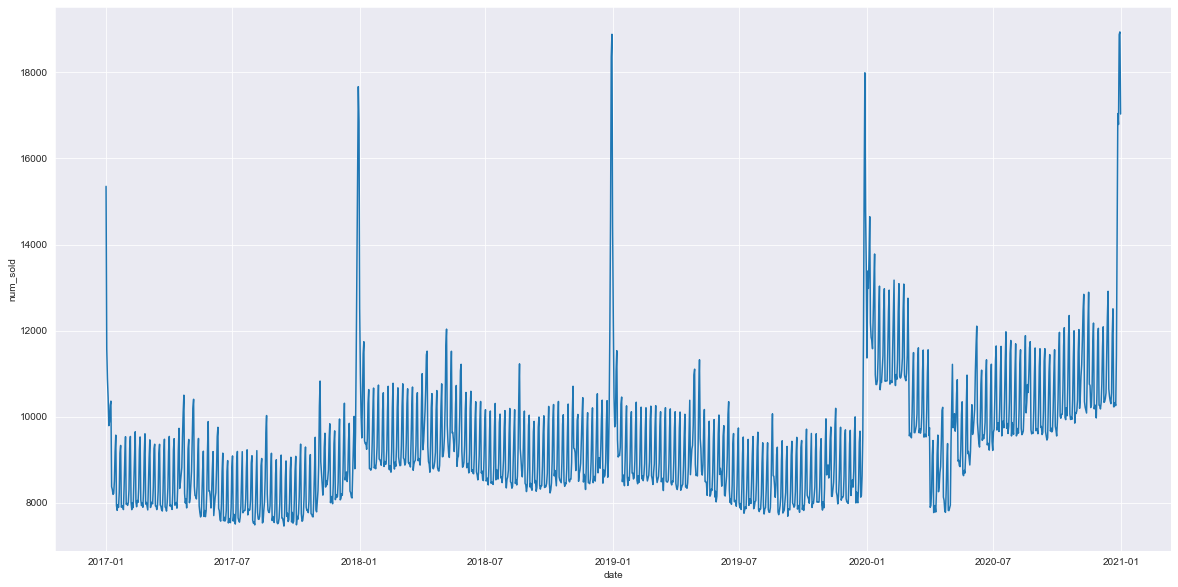

In [73]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = sold_df, x=DATE, y=NUM_SOLD);

This is the time series we need to forecast, the unusual nature of 2020 makes this forecast difficult.

In [74]:
sold_weekly_df = sold_df.groupby([pd.Grouper(key=DATE, freq="W")])[NUM_SOLD].sum().rename(NUM_SOLD).reset_index()
sold_monthly_df = sold_df.groupby([pd.Grouper(key=DATE, freq="MS")])[NUM_SOLD].sum().rename(NUM_SOLD).reset_index()

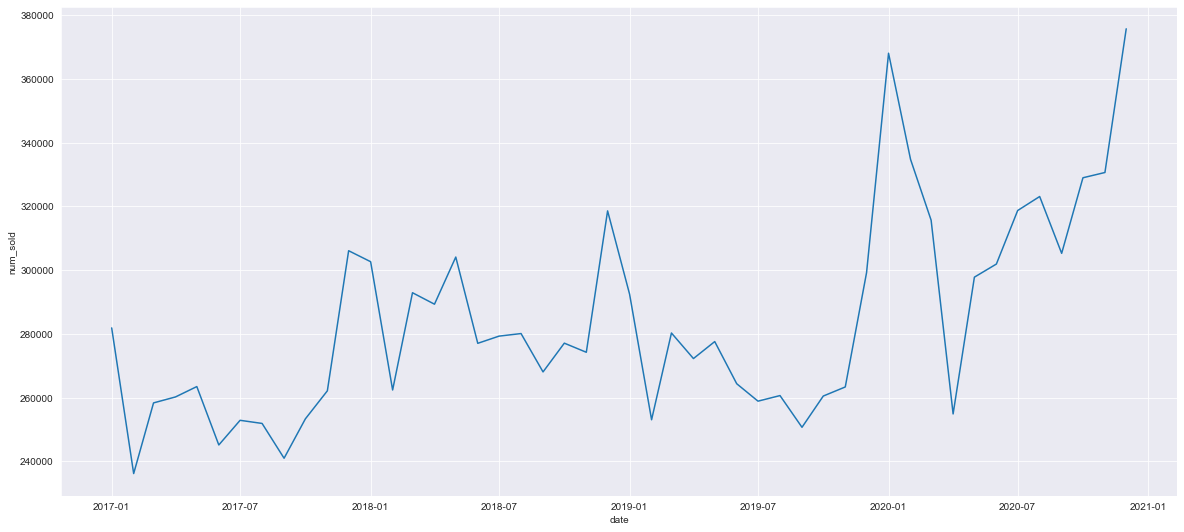

In [80]:
f,ax = plt.subplots(figsize=(20,9))
sns.lineplot(data=sold_monthly_df, x=DATE, y=NUM_SOLD);

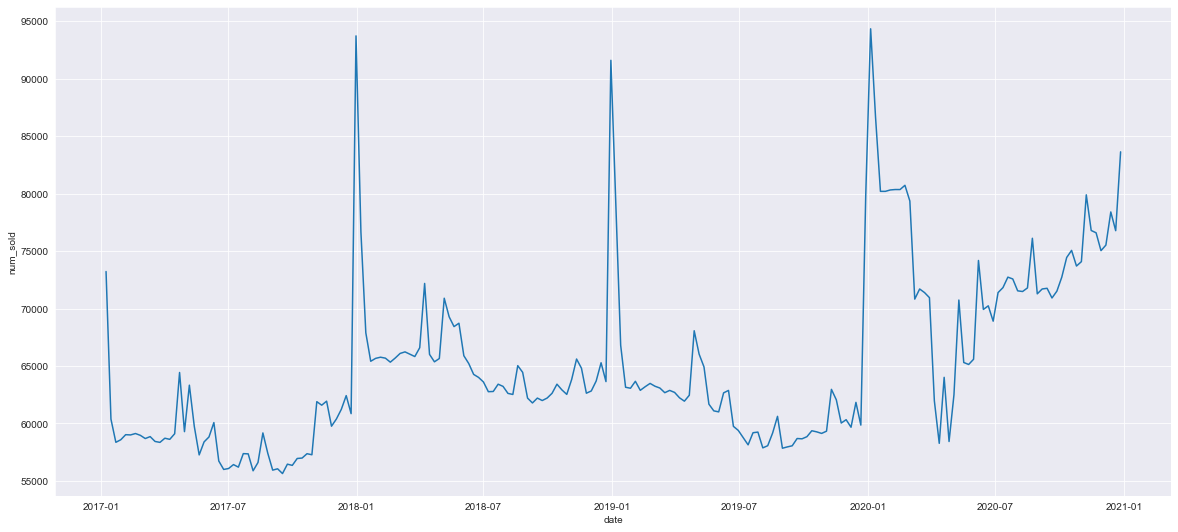

In [78]:
## not include first week and last week
f,ax = plt.subplots(figsize=(20,9))
sns.lineplot(data=sold_weekly_df[1:-1], x=DATE, y=NUM_SOLD);

## **Seasonality**

In [38]:
## add seasonlity labels
def seasonalize(df:pd.DataFrame):
    #remove the leap year date
    df = df.loc[df[DATE] != "2020-02-29"].copy()
    # df = df.copy()

    df["month"] = df[DATE].dt.month
    df["week"] = df[DATE].dt.isocalendar().week.astype('int64')
    df["dayofweek"] = df[DATE].dt.dayofweek
    df["dayofyear"] = df[DATE].dt.dayofyear
    #account for leap year
    df["dayofyear"] = df.apply(lambda x: x["dayofyear"]-1 if x[DATE] > pd.Timestamp("2020-02-29") else x["dayofyear"], axis=1)
    return df
seasonality_df = seasonalize(sold_df)

In [39]:
seasonality_df

date  num_sold  month  week  dayofweek  dayofyear
0    2017-01-01     15352      1    52          6          1
1    2017-01-02     11578      1     1          0          2
2    2017-01-03     10884      1     1          1          3
3    2017-01-04     10445      1     1          2          4
4    2017-01-05      9795      1     1          3          5
...         ...       ...    ...   ...        ...        ...
1456 2020-12-27     17042     12    52          6        361
1457 2020-12-28     16789     12    53          0        362
1458 2020-12-29     18876     12    53          1        363
1459 2020-12-30     18938     12    53          2        364
1460 2020-12-31     17031     12    53          3        365

[1460 rows x 6 columns]

In [120]:
def seasonality_plot(df:pd.DataFrame, x_axis:str):
    # the mean and 95% confidence interval of number sold by week, month, and year
        
    df_no_2020 = df.loc[df[DATE] < "2020-01-01"]

    f,axes = plt.subplots(2,1,figsize=(20,16))
    sns.lineplot(data=df, x=x_axis, y=NUM_SOLD, markers=True, ax=axes[0]);
    sns.lineplot(data=df_no_2020, x=x_axis, y=NUM_SOLD, markers=True, ax=axes[1]);
    axes[0].set_title("{} Seasonality - all years".format(x_axis), fontdict={"fontsize":20})
    axes[1].set_title("{} Seasonality - not including 2020".format(x_axis), fontdict={"fontsize":20})

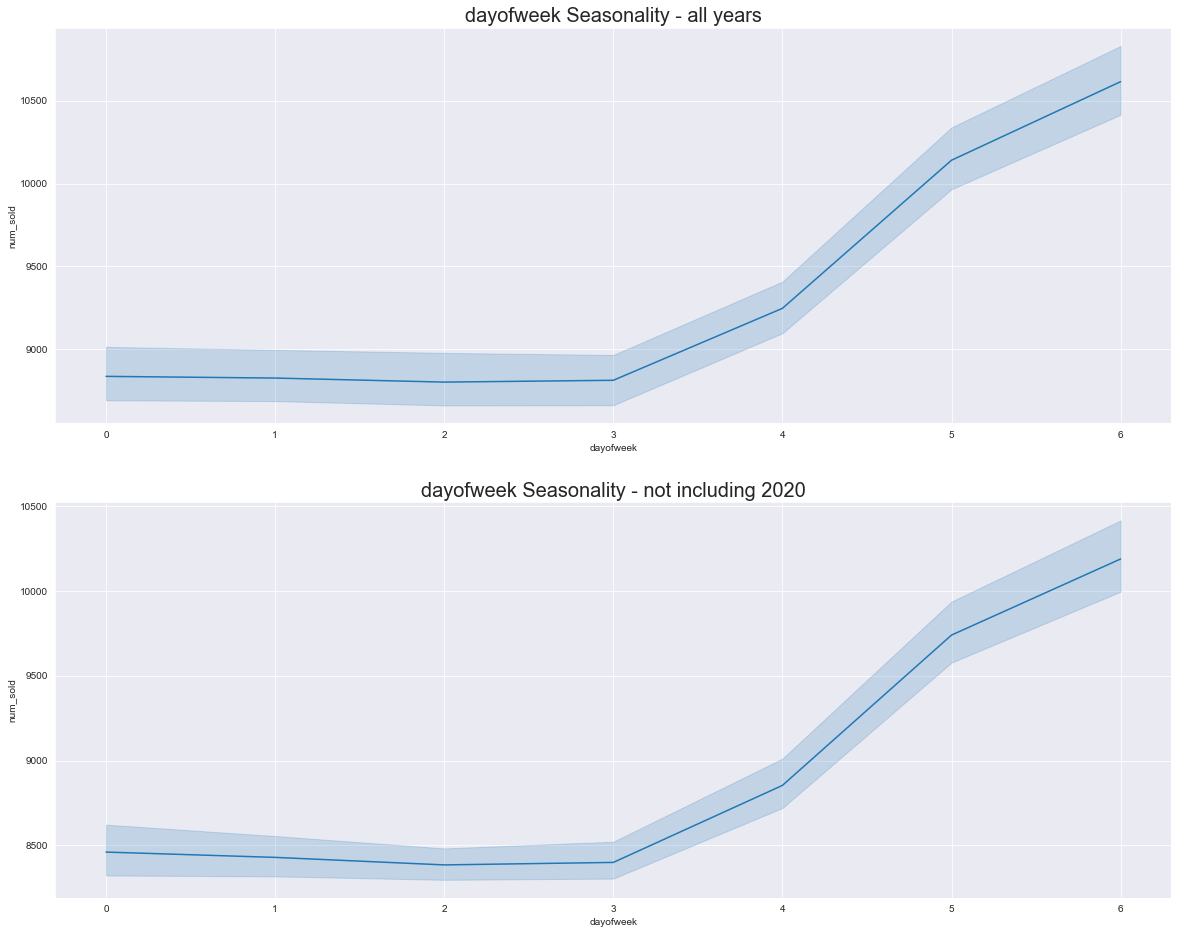

In [166]:
seasonality_plot(seasonality_df, "dayofweek")

**Insights**
- It can be conclude that weekday 0 to 3 can be regard as a class, and the others remains its class.

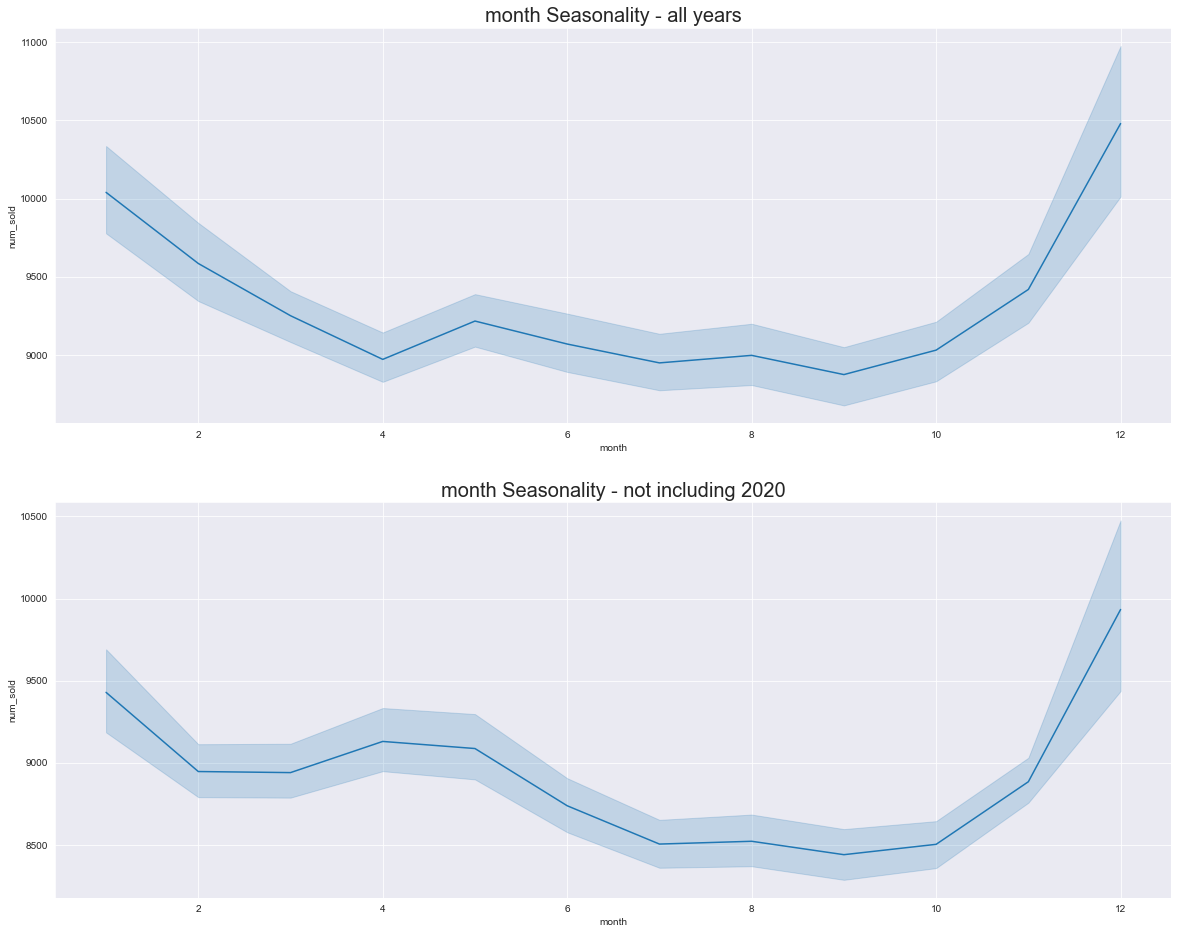

In [167]:
seasonality_plot(seasonality_df, "month")

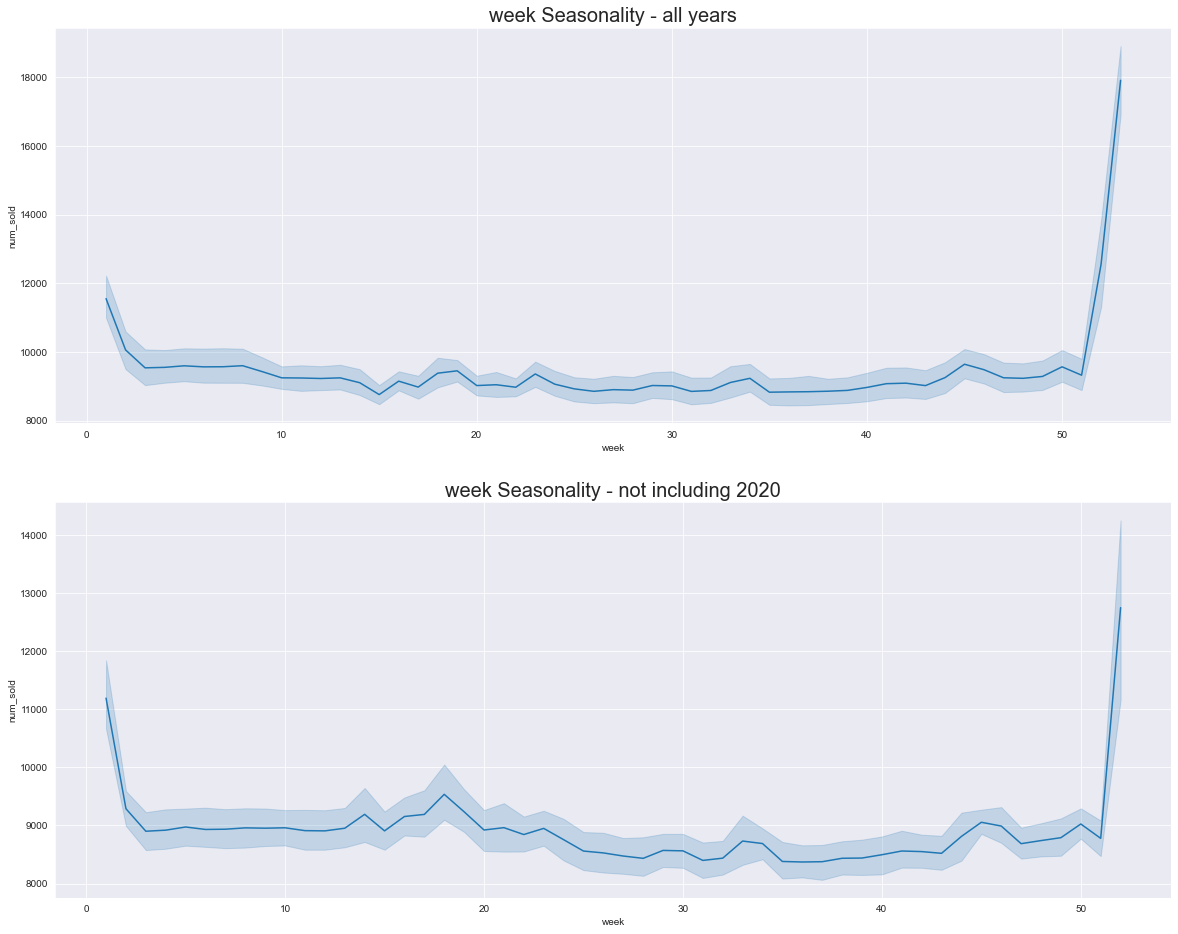

In [188]:
seasonality_plot(seasonality_df, "week")

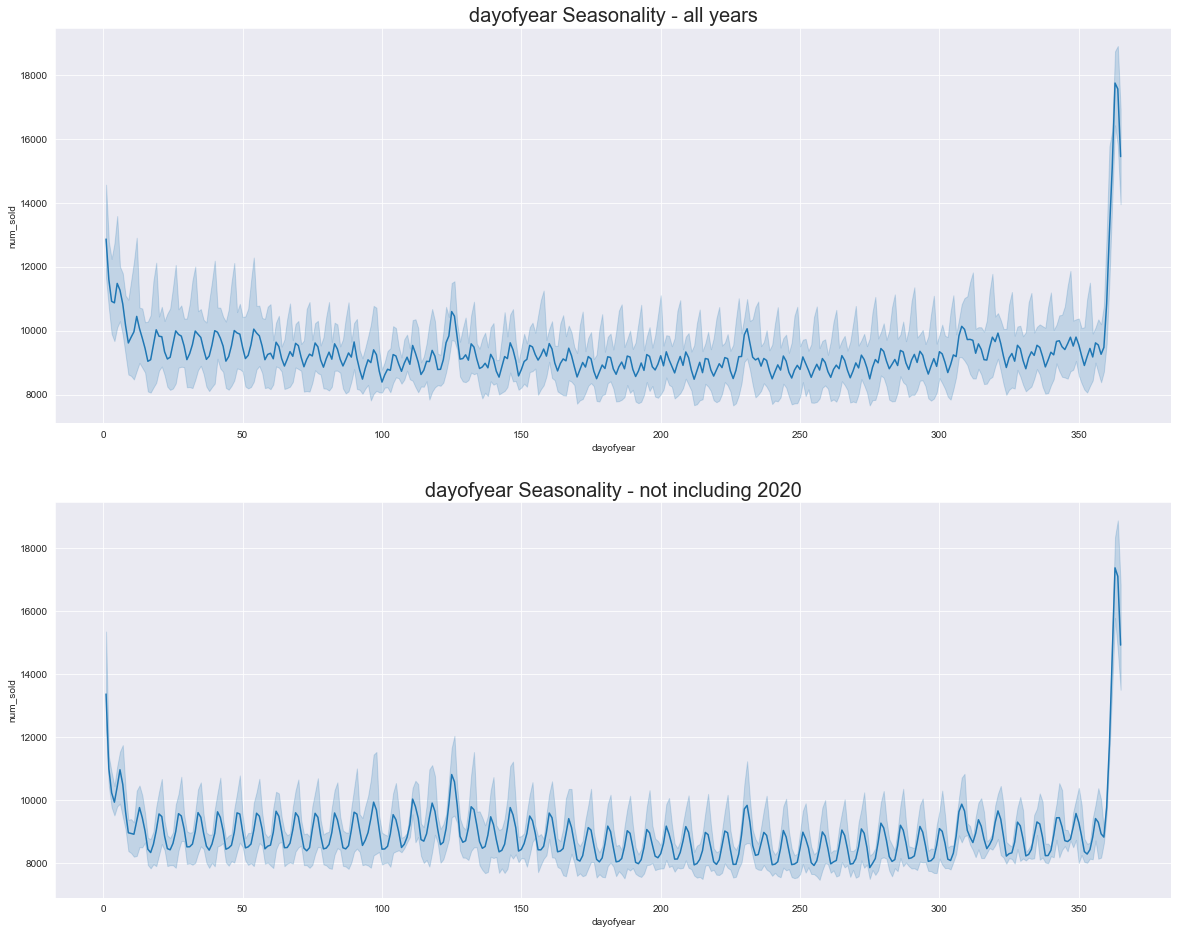

In [168]:
seasonality_plot(seasonality_df, "dayofyear")

# **Modeling**

We required 2 forecasts:

1. **Total Sales** Forecast
2. **Product Sales Ratio** Forecast

## **Total Sales Forecast**

Lets revist the graph of sales we wish to forecast:

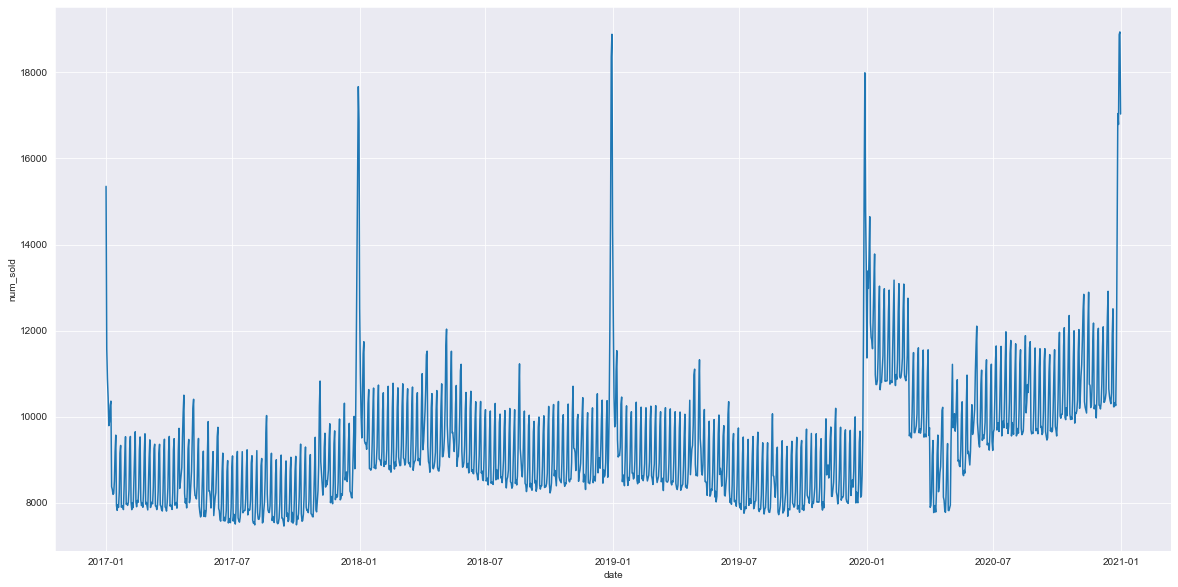

In [131]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = sold_df, x=DATE, y=NUM_SOLD);

There are atleast two important things to consider about 2020:
1. The number of sales from all countries becomes equal; massively increaseing the total number of products sold.
2. The impact of Covid, particuraly from around the dates March-May.

I am going to assume the first effect does not change in 2021. The second effect will change, to deal with this I'm going to completely exclude these months from the forecast.

In [40]:
train_nocovid_df = sold_df.loc[~((sold_df[DATE] >= "2020-03-01") & (sold_df[DATE] < "2020-06-01"))]

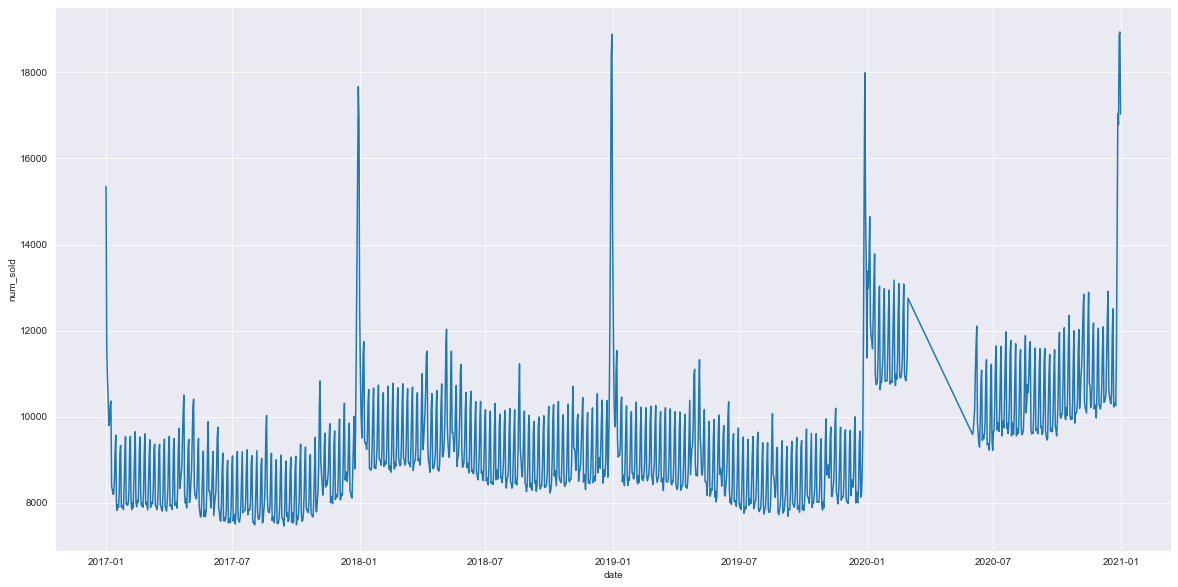

In [130]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = train_nocovid_df, x=DATE, y=NUM_SOLD);

In [41]:
#get the dates to forecast for
test_total_sales_df = test_df.groupby([DATE])[ROW_ID].first().reset_index().drop(columns=ROW_ID)
#keep dates for later
test_total_sales_dates = test_total_sales_df[[DATE]]

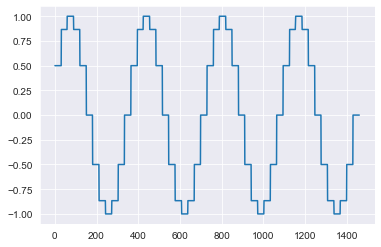

In [146]:
plt.plot(np.sin(seasonality_df['monthly'] * (2 * np.pi / 12)))

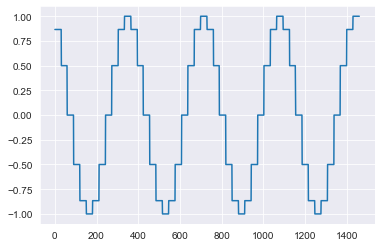

In [151]:
plt.plot(np.cos(seasonality_df['monthly'] * (2 * np.pi / 12)))


In [44]:
def feature_engineer(df:pd.DataFrame):
    new_df = df.copy()
    
    new_df["month"] = df[DATE].dt.month
    new_df["month_sin"] = np.sin(new_df['month'] * (2 * np.pi / 12))
    new_df["month_cos"] = np.cos(new_df['month'] * (2 * np.pi / 12))
    
    new_df["week"] = new_df[DATE].dt.isocalendar().week.astype('int64')
    new_df["important_weeks"] = new_df["week"].apply(lambda x: x if x in [1, 2, 14, 18, 31, 33, 45, 50, 52] else 0)
    
    new_df["day_of_week"] = df[DATE].dt.dayofweek
    new_df["day_of_week"] = new_df["day_of_week"].apply(lambda x: 0 if x<=3 else(1 if x==4 else (2 if x==5 else (3))))
    
    # new_df["day_of_year"] = df[DATE].dt.dayofyear
    # #account for leap year
    # new_df["day_of_year"] = new_df.apply(lambda x: x["day_of_year"]-1 if (x[DATE] > pd.Timestamp("2020-02-29") and x[DATE] < pd.Timestamp("2021-01-01"))  else x["day_of_year"], axis=1)
    
    # new_df["important_dates"] = new_df["day_of_year"].apply(lambda x: x if x in [1,2,3,4,5,6,7,8,125,126,360,361,362,363,364,365] else 0)
    
    
    # new_df["year"] = df[DATE].dt.year
    # new_df = new_df.drop(columns=["month", "day_of_year"])
    new_df = new_df.drop(columns=["month", "week"])
    
    ## one-hot encoding
    new_df = pd.get_dummies(new_df, columns = ["important_weeks","day_of_week"], drop_first=True)
    
    return new_df
    

In [45]:
train_engineered_df = feature_engineer(train_nocovid_df)
test_engineered_df = feature_engineer(test_total_sales_df)

In [46]:
display(train_engineered_df.head(2))
display(test_engineered_df.head(2))

date  num_sold  month_sin  month_cos  important_weeks_1  \
0 2017-01-01     15352        0.5   0.866025                  0   
1 2017-01-02     11578        0.5   0.866025                  1   

   important_weeks_2  important_weeks_14  important_weeks_18  \
0                  0                   0                   0   
1                  0                   0                   0   

   important_weeks_31  important_weeks_33  important_weeks_45  \
0                   0                   0                   0   
1                   0                   0                   0   

   important_weeks_50  important_weeks_52  day_of_week_1  day_of_week_2  \
0                   0                   1              0              0   
1                   0                   0              0              0   

   day_of_week_3  
0              1  
1              0

date  month_sin  month_cos  important_weeks_1  important_weeks_2  \
0 2021-01-01        0.5   0.866025                  0                  0   
1 2021-01-02        0.5   0.866025                  0                  0   

   important_weeks_14  important_weeks_18  important_weeks_31  \
0                   0                   0                   0   
1                   0                   0                   0   

   important_weeks_33  important_weeks_45  important_weeks_50  \
0                   0                   0                   0   
1                   0                   0                   0   

   important_weeks_52  day_of_week_1  day_of_week_2  day_of_week_3  
0                   0              1              0              0  
1                   0              0              1              0

In [47]:
y = train_engineered_df[NUM_SOLD]
X = train_engineered_df.drop(columns=[DATE, NUM_SOLD])
X_test = test_engineered_df.drop(columns=[DATE])

Define and fit the model, then make the forecast.

In [75]:
model = LinearRegression()
model.fit(X, y)
preds = model.predict(X_test)
test_engineered_df[NUM_SOLD] = preds

Visualising the forecast:

<AxesSubplot:xlabel='date', ylabel='num_sold'>

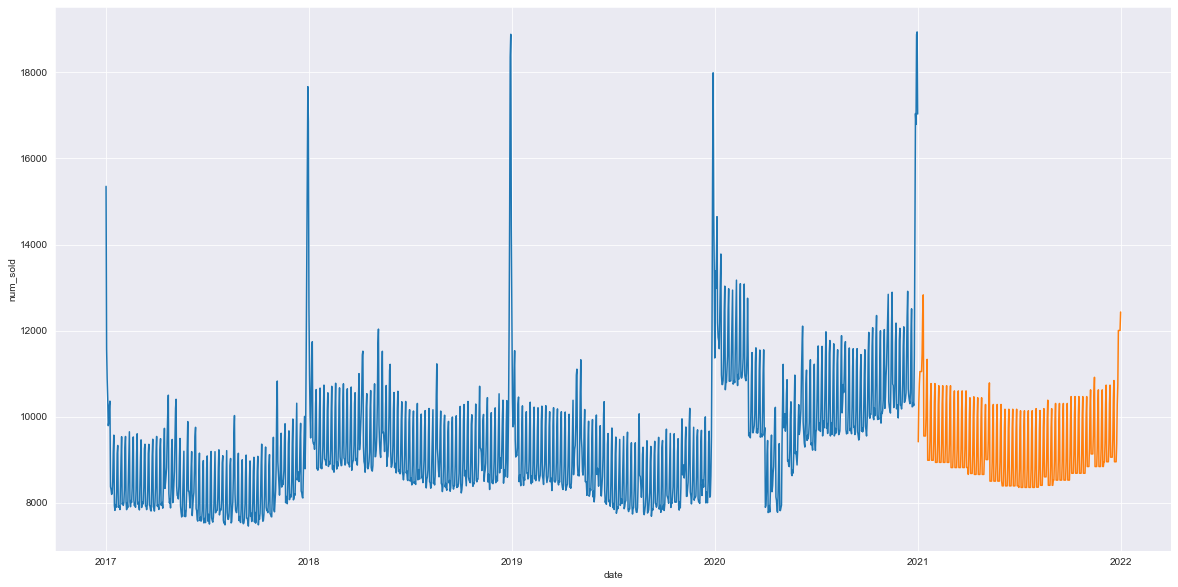

In [76]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = sold_df, x=DATE, y=NUM_SOLD)
sns.lineplot(data = test_engineered_df, x=DATE, y=NUM_SOLD)

The forecast looks okay, but theres room for improvement.

## **Product Ratio Forecast**

We now need to forecast the sales ratio between products for 2021.

The period of the product ratio sinsidual curves appear to be 2 years. So to forecast 2021 I resuse the ratios from 2019. This will carry over some of the noise which perhaps isn't ideal, but it'll work fine for a baseline.

In [80]:
product_ratio_2019 = product_ratio_df.loc[product_ratio_df[DATE].dt.year == 2019].copy()
product_ratio_2019["mm-dd"] = product_ratio_2019[DATE].dt.strftime('%m-%d')
product_ratio_2019 = product_ratio_2019.drop(columns=DATE)

test_product_ratio_df = test_df.copy()
test_product_ratio_df["mm-dd"] = test_product_ratio_df[DATE].dt.strftime('%m-%d')

test_product_ratio_df = pd.merge(test_product_ratio_df,product_ratio_2019, how="left", on = ["mm-dd", PRODUCT])
test_product_ratio_df.head()

row_id       date  country       store                           product  \
0   70128 2021-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques   
1   70129 2021-01-01  Belgium  KaggleMart            Kaggle Getting Started   
2   70130 2021-01-01  Belgium  KaggleMart                Kaggle Recipe Book   
3   70131 2021-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose   
4   70132 2021-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques   

   mm-dd    ratios  
0  01-01  0.279273  
1  01-01  0.230832  
2  01-01  0.188119  
3  01-01  0.301776  
4  01-01  0.279273

Visualising the forecast:

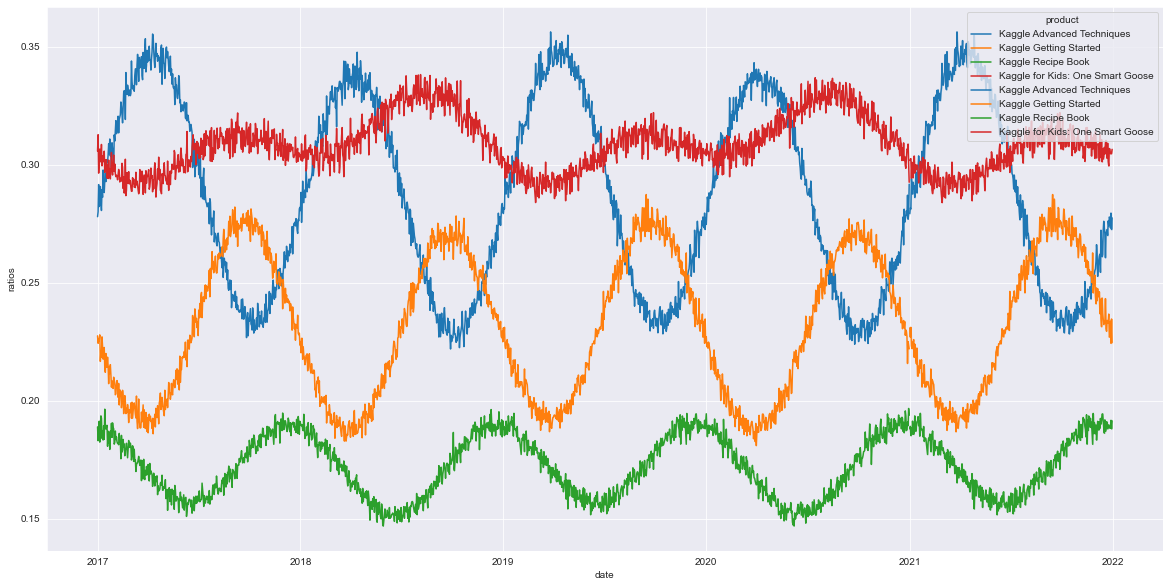

In [81]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=product_ratio_df, x=DATE, y=RATIOS, hue=PRODUCT);
sns.lineplot(data=test_product_ratio_df, x=DATE, y=RATIOS, hue=PRODUCT);

# **Disaggregating Total Sales Forecast**

Now we have our two required forecasts, we need to divide the total sales forecast between the categorical variables.

In [223]:
test_engineered_df[[DATE, NUM_SOLD]]

date      num_sold
0   2021-01-01  13744.616925
1   2021-01-02  13962.218701
2   2021-01-03  13776.198968
3   2021-01-04  11723.884771
4   2021-01-05  11859.657613
..         ...           ...
360 2021-12-27  13402.464060
361 2021-12-28  15086.712811
362 2021-12-29  16856.685653
363 2021-12-30  16792.949137
364 2021-12-31  15789.844965

[365 rows x 2 columns]

In [82]:
test_sub_df = pd.merge(test_df, test_engineered_df[[DATE, NUM_SOLD]], how="left")
test_sub_df[RATIOS] = test_product_ratio_df[RATIOS]
test_sub_df.head()

row_id       date  country       store                           product  \
0   70128 2021-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques   
1   70129 2021-01-01  Belgium  KaggleMart            Kaggle Getting Started   
2   70130 2021-01-01  Belgium  KaggleMart                Kaggle Recipe Book   
3   70131 2021-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose   
4   70132 2021-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques   

      num_sold    ratios  
0  9420.194877  0.279273  
1  9420.194877  0.230832  
2  9420.194877  0.188119  
3  9420.194877  0.301776  
4  9420.194877  0.279273

In [83]:
def disaggregate_forecast(df:pd.DataFrame):
    new_df = df.copy()
    
    stores_weights = original_train_df.groupby(STORE)[NUM_SOLD].sum()/original_train_df[NUM_SOLD].sum()
    country_weights = pd.Series(index = test_sub_df[COUNTRY].unique(),data = 1/6)

    for country in country_weights.index:
        new_df.loc[(new_df[COUNTRY] == country), NUM_SOLD] *= country_weights[country]
        
    for store in stores_weights.index:
        new_df.loc[new_df[STORE] == store, NUM_SOLD] *= stores_weights[store]
    
    #apply product weights (which is dependent on date)
    new_df[NUM_SOLD] *= new_df[RATIOS]
    new_df[NUM_SOLD] = new_df[NUM_SOLD].round()
    new_df = new_df.drop(columns=[RATIOS])
    
    return new_df

In [84]:
final_df = disaggregate_forecast(test_sub_df)
final_df

row_id       date  country       store  \
0       70128 2021-01-01  Belgium  KaggleMart   
1       70129 2021-01-01  Belgium  KaggleMart   
2       70130 2021-01-01  Belgium  KaggleMart   
3       70131 2021-01-01  Belgium  KaggleMart   
4       70132 2021-01-01  Belgium  KaggleRama   
...       ...        ...      ...         ...   
17515   87643 2021-12-31    Spain  KaggleMart   
17516   87644 2021-12-31    Spain  KaggleRama   
17517   87645 2021-12-31    Spain  KaggleRama   
17518   87646 2021-12-31    Spain  KaggleRama   
17519   87647 2021-12-31    Spain  KaggleRama   

                                product  num_sold  
0            Kaggle Advanced Techniques     326.0  
1                Kaggle Getting Started     269.0  
2                    Kaggle Recipe Book     219.0  
3      Kaggle for Kids: One Smart Goose     352.0  
4            Kaggle Advanced Techniques     113.0  
...                                 ...       ...  
17515  Kaggle for Kids: One Smart Goose     472.0  
17516        Kaggle Advanced Techniques     148.0  
17517            Kaggle Getting Started     120.0  
17518                Kaggle Recipe Book     102.0  
17519  Kaggle for Kids: One Smart Goose     164.0  

[17520 rows x 6 columns]

Finally lets visualise the forecasts for all countries, products and stores:

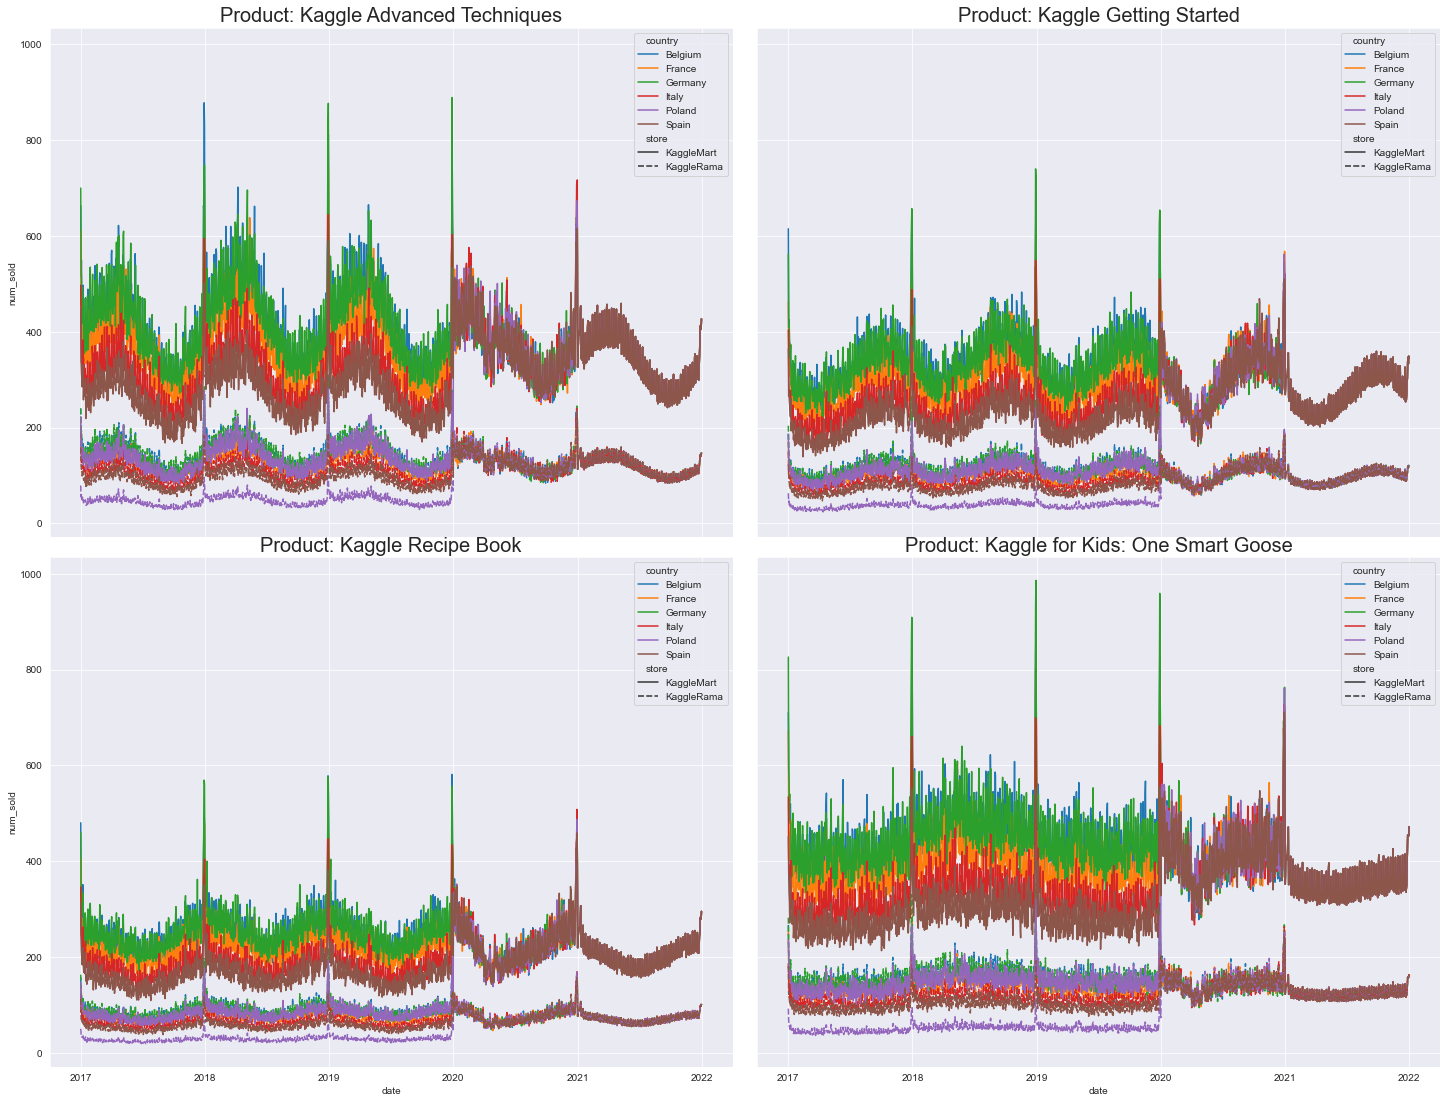

In [85]:
plot_all(pd.concat([original_train_df,final_df]).reset_index(drop=True))

# **Submission**

In [86]:
submission = pd.read_csv("data/sample_submission.csv")
submission[NUM_SOLD] = final_df[NUM_SOLD]

In [87]:
display(submission.head())

row_id  num_sold
0   70128     326.0
1   70129     269.0
2   70130     219.0
3   70131     352.0
4   70132     113.0

In [88]:
submission.to_csv('submission_OLS.csv', index = False)